In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

seed = np.random.seed(0)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 1000)

In [2]:
train_data_apartments = pd.read_csv("data/apartments_train.csv")
train_data_buildings = pd.read_csv("data/buildings_train.csv")

train_data = pd.merge(train_data_apartments, train_data_buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
num_of_training_samples = train_data.shape[0]
# Don't drop outliers, as it worsens submit performance
y_train = (np.asarray(train_data.price))

test_data_apartments = pd.read_csv("data/apartments_test.csv")
test_data_buildings = pd.read_csv("data/buildings_test.csv")

test_data = pd.merge(test_data_apartments, test_data_buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
test_ids = test_data.id

train_data = train_data.drop("id", axis = 1)
test_data = test_data.drop("id", axis = 1)

metro_coordinates = pd.read_csv("data/metro.csv")

print("Amount of duplicates in training data: ", len(train_data[train_data.duplicated()]))


Amount of duplicates in training data:  465


Amount of ceilings higher than 200m:  31
Amount of ceilings between 25m and 200m:  8


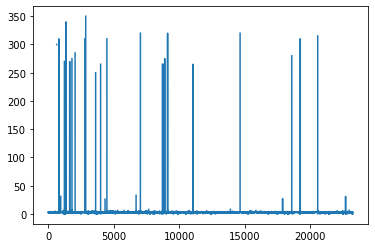

In [3]:
all_data = pd.concat([train_data, test_data])

plt.plot(all_data.ceiling)
print("Amount of ceilings higher than 200m: ", len(all_data.ceiling[all_data.ceiling >200]))
print("Amount of ceilings between 25m and 200m: ", len(all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)]))
# Rescaling out of scale ceilings
all_data.ceiling[all_data.ceiling > 200] = all_data.ceiling/100
all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)] = all_data.ceiling/10

In [4]:
def haversine_array(lat1, lng1, lat2 = 55.75, lng2 = 37.6):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [5]:
def euclid_dist_from_center(lat, long, lat2 = 55.75, long2 = 37.6):

    return np.sqrt(np.power(np.abs(lat2 - lat), 2) + np.power(np.abs(long2 - long), 2))

In [6]:
# Unifying street and address
all_data["street_and_address"] = all_data.street + " " + all_data.address
# Adding shared and private bathrooms
all_data["bathrooms"] = all_data.bathrooms_shared  + all_data.bathrooms_private
# Adding balconies and loggias
all_data["balconies_and_loggias"] = all_data.balconies + all_data.loggias

# Imputing coordinates outside of moscow and NaNs

#Бунинские Луга ЖК к2/2/1 = Ulitsa Aleksandry Monakhovoy, 97, coordinates: 55.5415152, 37.4821752
# улица 1-я Линия 57, coordinates: 55.6324711, 37.4536057
#улица Центральная 75 and 48, ESTIMATED coordinates: 55.750651,37.6083208
# пос. Коммунарка Москва А101 ЖК. coordinates: 55.5676692, 37.4816608
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 37.4821752
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица 1-я Линия 57"] = 55.6324711
all_data.longitude[all_data.street_and_address == "улица 1-я Линия 57"] = 37.4536057
all_data.latitude[all_data.street_and_address == "улица Центральная 75"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 75"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица Центральная 48"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 48"] = 37.4821752
# NaNs
all_data.latitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 55.5676692
all_data.longitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 37.4816608



# New feature: Euclidean distance from the city center
all_data["dist_from_city_center"] = haversine_array(all_data.latitude, all_data.longitude)
all_data = all_data.drop(["address", "street", "bathrooms_shared", "bathrooms_private", "balconies", "loggias",
"windows_court", "windows_street", "elevator_service", "elevator_passenger", "garbage_chute", 
"layout", "parking", "heating", "elevator_without", "new", "building_id"], axis = 1)



In [7]:
broadcasted_lat = np.broadcast_to(np.expand_dims(np.asarray(all_data.latitude), axis = 1), (33222,268))
broadcasted_long = np.broadcast_to(np.expand_dims(np.asarray(all_data.longitude), axis = 1), (33222,268))

broadcasted_metro_lat = np.broadcast_to(np.expand_dims(np.asarray(metro_coordinates.latitude), axis=1).T, (33222,268))
broadcasted_metro_long = np.broadcast_to(np.expand_dims(np.asarray(metro_coordinates.longitude), axis=1).T, (33222,268))

#print(np.sum((haversine_array(broadcasted_lat, broadcasted_long, broadcasted_metro_lat, broadcasted_metro_long) <= 5), axis = 1))

all_data["metros_in_5km"] = np.sum((haversine_array(broadcasted_lat, broadcasted_long, broadcasted_metro_lat, broadcasted_metro_long) <= 5), axis = 1)
print(all_data.metros_in_5km)

0        6
1       13
2       15
3       13
4        7
        ..
9932    19
9933    39
9934     3
9935    36
9936     0
Name: metros_in_5km, Length: 33222, dtype: int32


In [8]:
#print(all_data.latitude[np.isnan(all_data.district)].values)
#print((all_data.longitude[np.isnan(all_data.district)]).values)
#print(all_data.groupby("district").mean().longitude)
#print(all_data.groupby("district").mean().latitude)

all_data.district[(all_data.latitude==55.59516) & (all_data.longitude==37.741109)] = 5.0
all_data.district[(all_data.latitude==55.5676692) & (all_data.longitude==37.4816608)] = 11.0
all_data.district[(all_data.latitude==55.921627) & (all_data.longitude==37.781578)] = 3.0
all_data.district[(all_data.latitude==55.5415152) & (all_data.longitude==37.4821752)] = 11.0
all_data.district[(all_data.latitude==55.6324711) & (all_data.longitude==37.4536057)] = 6.0
all_data.district[(all_data.latitude==55.583551) & (all_data.longitude==37.711356)] = 5.0
all_data.district[(all_data.latitude==55.932127) & (all_data.longitude==37.793705)] = 3.0

In [9]:
print("Amount of duplicates in all data: ", len(all_data[all_data.duplicated()]))
# Drop dups from imputation data
all_data_no_dups = all_data.drop(all_data[all_data.duplicated()].index, axis = 0)
# Drop dups from training data
print("Amount of duplicates in all data without duplicates: ", len(all_data_no_dups[all_data_no_dups.duplicated()]))

Amount of duplicates in all data:  768
Amount of duplicates in all data without duplicates:  0


Imputation

In [10]:
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["seller", "condition", "material", "street_and_address"]
numerical_columns = ["area_total", "area_living", "area_kitchen", "bathrooms", "floor", "rooms", "ceiling", "phones", "balconies_and_loggias", "constructed", "stories"]
boolean_columns = []
# Encode string-addresses into integers
string_encoder = LabelEncoder()
all_data["street_and_address"] = string_encoder.fit_transform(all_data.street_and_address)

categorical_imputer = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
categorical_imputer.fit(all_data_no_dups[categorical_columns])
all_data[categorical_columns] = categorical_imputer.transform(all_data[categorical_columns])

all_data.fillna(-999, inplace = True)


In [11]:
train_data = all_data[0:num_of_training_samples]
test_data = all_data[num_of_training_samples:len(all_data)]
#print(test_data.head(100))

print("Amount of duplicates in train data: ", len(train_data[train_data.duplicated()]))
train_data = train_data.drop(train_data[train_data.duplicated()].index, axis = 0)

price_per_district = train_data.groupby("district").mean().price
area_per_district = train_data.groupby("district").mean().area_total

train_data["price_per_sq_dist_cat"], bins = pd.qcut(train_data.dist_from_city_center, q = 150, retbins = True)
test_data["price_per_sq_dist_cat"] = pd.cut(test_data.dist_from_city_center, bins = bins)

price_per_dist = train_data.groupby("price_per_sq_dist_cat").mean().price
area_per_dist = train_data.groupby("price_per_sq_dist_cat").mean().area_total

a = np.log(price_per_district/area_per_district)
b = np.log(price_per_dist/area_per_dist)

train_data = pd.concat([train_data, pd.DataFrame(columns = ["sqm_per_dist"])], axis = 1)
test_data = pd.concat([test_data, pd.DataFrame(columns = ["sqm_per_dist"])], axis = 1)

train_data["district"] = train_data["district"].map(a).astype(float)
test_data["district"] = test_data["district"].map(a).astype(float)

train_data["sqm_per_dist"] = train_data["price_per_sq_dist_cat"].map(b).astype(float)
test_data["sqm_per_dist"] = test_data["price_per_sq_dist_cat"].map(b).astype(float)

train_data = train_data.drop("price_per_sq_dist_cat", axis = 1)
test_data = test_data.drop("price_per_sq_dist_cat", axis = 1)

Amount of duplicates in train data:  510


In [12]:
train_data.area_total = np.log1p(train_data.area_total)
test_data.area_total = np.log1p(test_data.area_total)

In [13]:
print(len(test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center < b.index[0].right)]))
print(len(test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center > b.index[len(b)-1].left)]))


print(len(test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center < b.index[0].right)]))
print(len(test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center > b.index[len(b)-1].left)]))

test_data.district[(np.isnan(test_data.district)) & (test_data.district < a[0])] = a[0]
test_data.district[(np.isnan(test_data.district)) & (test_data.district > a[len(a)-1])] = a[len(a)-1]

test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center < b.index[0].right)] = b[0]
test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center > b.index[len(b)-1].left)] = b[len(b)-1]



83
0
83
0


In [14]:
y_train = train_data.price
x_train = train_data.drop("price", axis = 1)
test_data = test_data.drop("price", axis = 1)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
test_data = np.asarray(test_data)

In [15]:
from tensorflow.keras.losses import mean_squared_logarithmic_error
from tensorflow.keras.backend import sqrt

def root_mean_squared_log_error(y_true, y_pred):
    return sqrt(mean_squared_logarithmic_error(y_true, y_pred))

In [16]:

from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(
    n_estimators=100,
    criterion='mse',
    max_depth=None,
#    min_samples_split=2,
#    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet, RidgeCV, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor


model5 = LGBMRegressor(
    objective="regression",
    num_leaves=32,
    max_depth=5, 
    random_state=42, 
    metric='mse',
    n_jobs=-2, 
    n_estimators=5000,
    colsample_bytree=0.7,
    subsample=0.7,
    verbose = -1
)

model_xgb_1 = XGBRegressor(
    n_estimators=1500,
    max_depth=5,
    n_jobs=-2,
    booster='gbtree',
    enable_categorical = True,
    colsample_bytree=0.7,
    subsample=0.7,
    learning_rate = 0.1,
    random_state=42069
)

model_cat_1 = CatBoostRegressor(
    iterations=2000,
    depth = 7,
    learning_rate=0.1,
    l2_leaf_reg=0.45,
    silent=True,
    random_seed = 42069
)

final_model = RidgeCV()


base_learners = [
    ('xgb_tree', model_xgb_1),
    #("random_forest", model2),
    ("lgbm", model5),
    # ('knn_256', model3),
    #('knn_512', model_knn_512),
    # ('knn_1024', model5),
    ('catboost', model_cat_1),
]

stacking_model = StackingRegressor(estimators=base_learners, n_jobs=-2, final_estimator=final_model, cv = 5, verbose = 1)


In [18]:
from sklearn.model_selection import KFold
i = 0
models = []
errors = []
predictions_test = []
kf = KFold(random_state = 42069, shuffle = True)
for train_index, test_index in kf.split(x_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    current_model = stacking_model.fit(x_train_fold, np.log(y_train_fold))
    models.append(current_model)
    predictions_val = np.exp(stacking_model.predict(x_test_fold))
    errors.append(root_mean_squared_log_error(y_test_fold, predictions_val))

    predictions_test.append(np.exp(stacking_model.predict(test_data)))

    print("Error: ", root_mean_squared_log_error(y_test_fold, predictions_val))
print("Mean error: ", np.mean(errors))

TRAIN: [    0     1     2 ... 22772 22773 22774] TEST: [   10    14    15 ... 22764 22769 22770]
Error:  tf.Tensor(0.1218908267105606, shape=(), dtype=float64)
TRAIN: [    0     1     3 ... 22771 22773 22774] TEST: [    2     5     6 ... 22752 22767 22772]


In [ ]:
print(predictions_test)
prediction = np.mean(predictions_test, axis = 0)
print(prediction)
submission = pd.DataFrame()
submission['id'] = test_ids
submission["price_prediction"] = prediction
submission.to_csv('simple_nn_submission.csv', index=False)

[array([30100964.5585079 ,  9299808.25180861,  6183285.82176589, ...,
        9564215.00347241,  9470641.29453873,  6118126.45317173]), array([31008178.05931112,  9602708.56762006,  6196128.37217469, ...,
        9697073.01529679,  9792083.50368488,  5935828.92918098]), array([31497212.02341629,  9503246.88518952,  6205689.58530221, ...,
        9164684.69903585, 10009487.13786568,  6749335.82164923]), array([31410627.46421756,  9297378.38472123,  6180489.84156825, ...,
        9168052.53048579,  9934750.27394835,  6405823.02005518]), array([32739957.23017579,  9723985.40725389,  6188402.31604073, ...,
        9478350.85706558,  9312227.12294799,  6427531.0582105 ])]
[31351387.86712574  9485425.49931866  6190799.18737035 ...
  9414475.22107128  9703837.86659713  6327329.05645352]
